In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import Libraries

import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

/Users/yashtaneja/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# -----------------------------
# Dataset paths

train_real_path = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/REAL"
train_fake_path = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/FAKE"
test_real_path = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/REAL"
test_fake_path = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/FAKE"


In [4]:
# Parameters
# -----------------------------
IMG_SIZE = (224, 224)  # VGG19 input size
MAX_IMAGES = 2000      # 1000 per class to save memory

In [5]:
# Load images function
# -----------------------------
def load_images(folder, label, limit=1000):
    X, y = [], []
    files = os.listdir(folder)[:limit]
    for f in files:
        try:
            img = load_img(os.path.join(folder, f), target_size=IMG_SIZE)
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)  # scale for VGG19
            X.append(img_array)
            y.append(label)
        except:
            continue
    return np.array(X), np.array(y)

# Load training images
X_real, y_real = load_images(train_real_path, 0, MAX_IMAGES)
X_fake, y_fake = load_images(train_fake_path, 1, MAX_IMAGES)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/REAL'

In [ ]:
X_train = np.vstack((X_real, X_fake))
y_train = np.hstack((y_real, y_fake))

In [ ]:
# Load test images
X_real_test, y_real_test = load_images(test_real_path, 0, MAX_IMAGES)
X_fake_test, y_fake_test = load_images(test_fake_path, 1, MAX_IMAGES)

X_test = np.vstack((X_real_test, X_fake_test))
y_test = np.hstack((y_real_test, y_fake_test))

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (4000, 224, 224, 3) Test shape: (4000, 224, 224, 3)


## **VGG19 Model**

In [ ]:
# VGG19 base model
# -----------------------------
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

I0000 00:00:1757179045.169389      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Build classifier on top
# -----------------------------
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

In [ ]:
# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,447,425 (100.89 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# Train model
# -----------------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32
)

Epoch 1/15


I0000 00:00:1757179055.325446      61 service.cc:148] XLA service 0x7bf4e400da40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757179055.326144      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757179055.766122      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/100 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.6250 - loss: 1.8611  

I0000 00:00:1757179064.149245      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - accuracy: 0.7254 - loss: 1.3435 - val_accuracy: 0.6812 - val_loss: 0.8304
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.8730 - loss: 0.3026 - val_accuracy: 0.8100 - val_loss: 0.4537
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.9297 - loss: 0.1869 - val_accuracy: 0.8200 - val_loss: 0.4328
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.9681 - loss: 0.0965 - val_accuracy: 0.8687 - val_loss: 0.3573
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.9687 - loss: 0.0799 - val_accuracy: 0.7837 - val_loss: 0.6055
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.9838 - loss: 0.0533 - val_accuracy: 0.8288 - val_loss: 0.4853
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.9917 - loss: 0.0358 - val_accuracy: 0.8112 - val_loss: 0.6077
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.9863 - loss: 0.0385 - val

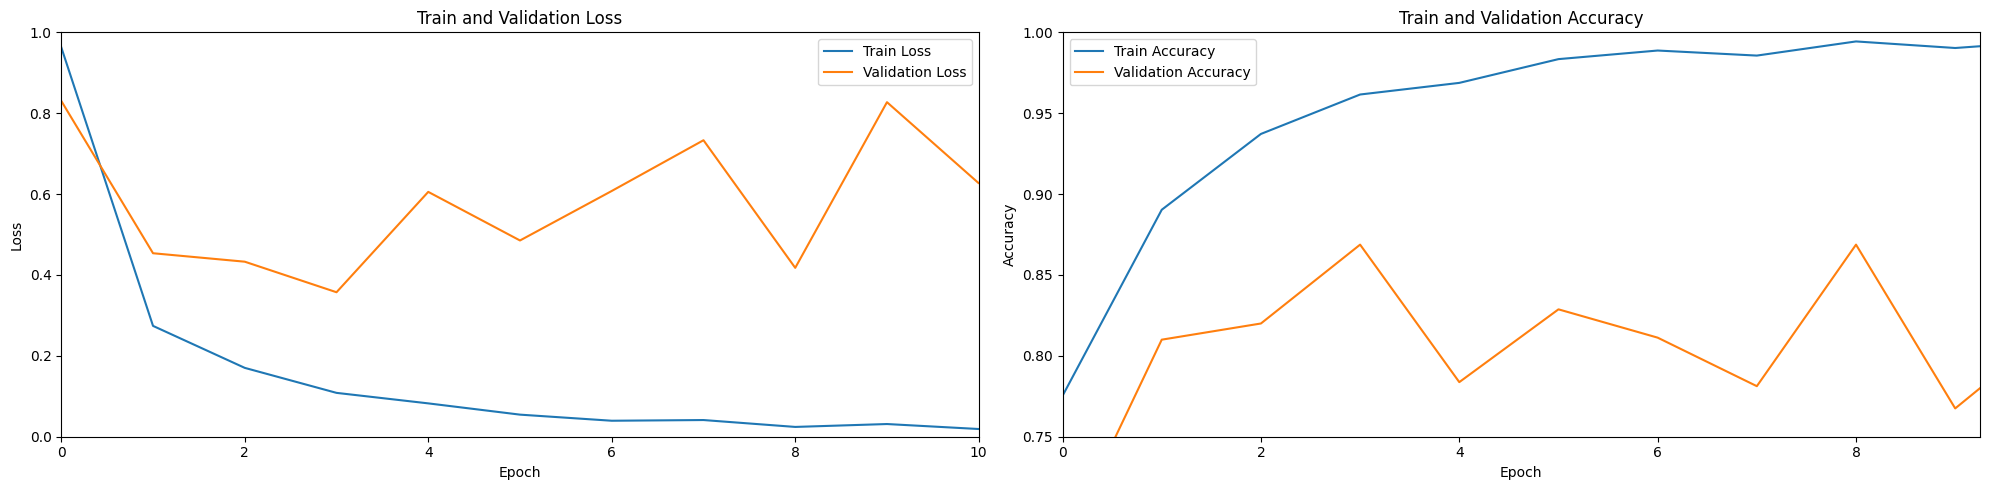

In [ ]:
# Plot the evaluation graph
import matplotlib.pyplot as plt

plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [ ]:
# Model Evaluation
# -----------------------------

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89      2000
           1       0.92      0.86      0.89      2000

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000

Confusion Matrix:
 [[1843  157]
 [ 279 1721]]


## **Efficient Net Model**

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
#from tensorflow.keras.applications.EfficientNetB0 import EfficientNetB0, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# EfficientNetB0 base model
# -----------------------------
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Build the model on top of the pre-trained base
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

# Compile the model
model.compile(optimizer= Adam(learning_rate=0.0001),
              loss='binary_crossentropy',  
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    32,113,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,294,308 (138.45 MB)

 Trainable params: 32,244,737 (123.00 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Train model
# -----------------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32
)

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - accuracy: 0.6423 - loss: 0.8113 - val_accuracy: 0.5863 - val_loss: 0.7626
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.7578 - loss: 0.5063 - val_accuracy: 0.7150 - val_loss: 0.5608
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.7875 - loss: 0.4584 - val_accuracy: 0.7700 - val_loss: 0.4642
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8033 - loss: 0.4119 - val_accuracy: 0.7550 - val_loss: 0.5253
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8211 - loss: 0.3913 - val_accuracy: 0.8438 - val_loss: 0.3773
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8355 - loss: 0.3657 - val_accuracy: 0.6875 - val_loss: 0.5875
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8454 - loss: 0.3425 - val_accuracy: 0.6825 - val_loss: 0.6841
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8480 - loss: 0.3413 - val_ac

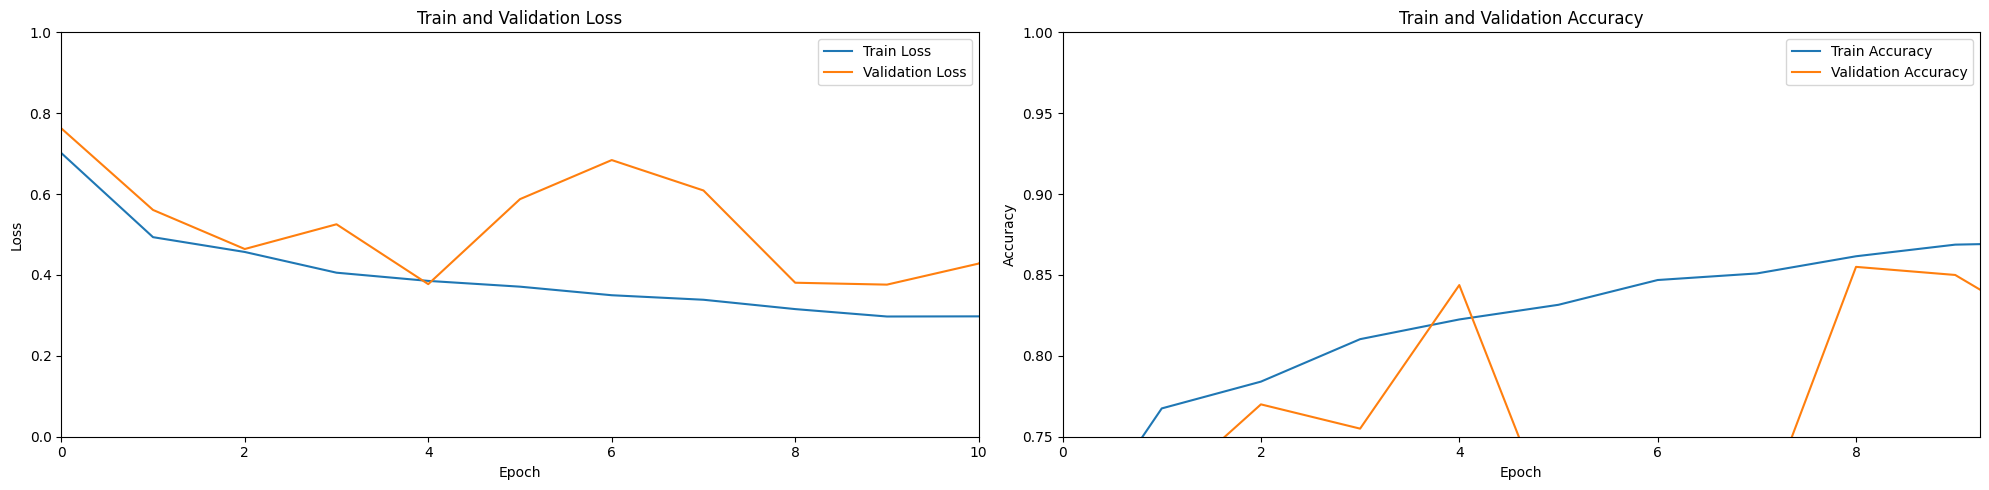

In [ ]:
# Plot the evaluation graph
import matplotlib.pyplot as plt

plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [ ]:
# Model Evaluation
# -----------------------------

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.87      2000
           1       0.88      0.85      0.87      2000

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000

Confusion Matrix:
 [[1771  229]
 [ 297 1703]]


## **ResNet**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [ ]:
# ResNet50 base model
# ---------------------------

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Build classifier on top
# ---------------------------
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,968,961 (285.98 MB)

 Trainable params: 51,381,249 (196.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Train model
# -----------------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32
)

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 120ms/step - accuracy: 0.7116 - loss: 2.2493 - val_accuracy: 0.8537 - val_loss: 0.3375
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9193 - loss: 0.2052 - val_accuracy: 0.8562 - val_loss: 0.3420
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9624 - loss: 0.1180 - val_accuracy: 0.7763 - val_loss: 0.5976
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9793 - loss: 0.0637 - val_accuracy: 0.8037 - val_loss: 0.5326
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9828 - loss: 0.0517 - val_accuracy: 0.8763 - val_loss: 0.3278
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9887 - loss: 0.0357 - val_accuracy: 0.9388 - val_loss: 0.1736
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9906 - loss: 0.0282 - val_accuracy: 0.8338 - val_loss: 0.5414
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.9943 - loss: 0.0211 - val_ac

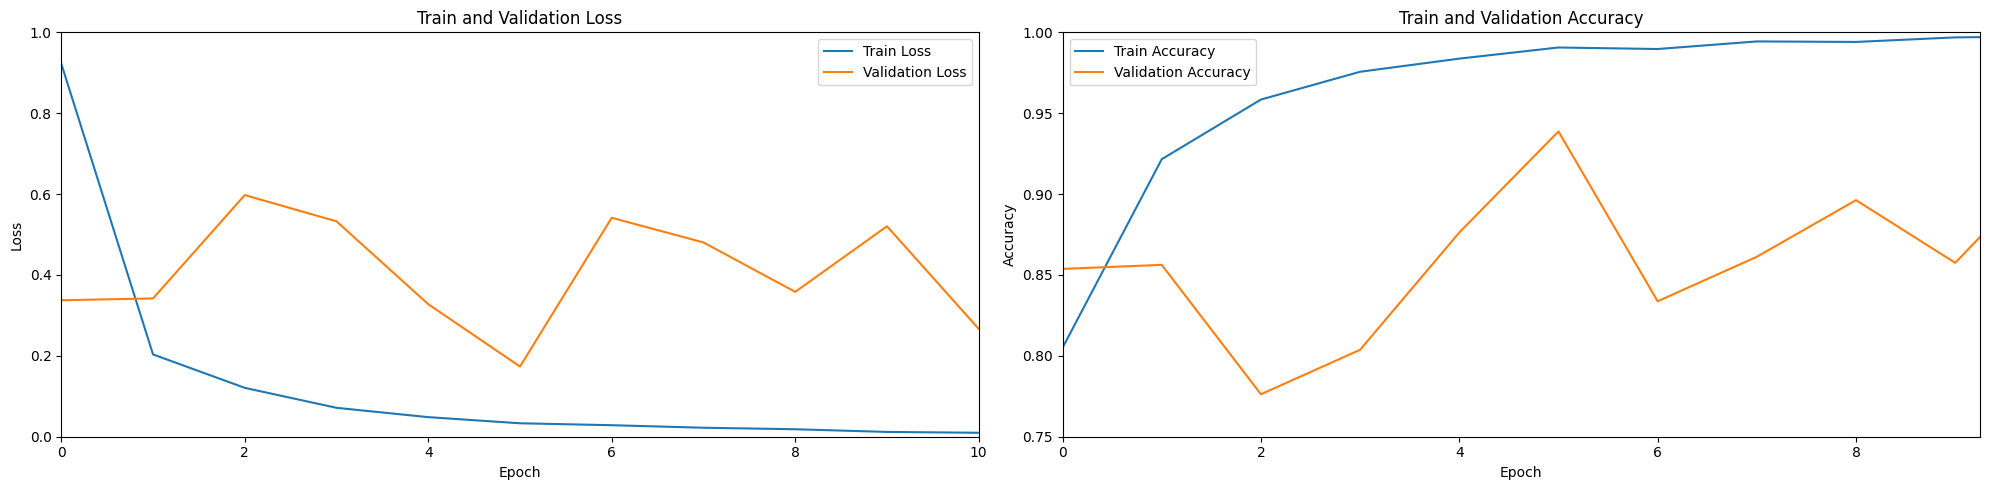

In [ ]:
# Plot the evaluation graph
# -------------------------

import matplotlib.pyplot as plt

plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [ ]:
# Model Evaluation
# -----------------------------

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93      2000
           1       0.95      0.90      0.92      2000

    accuracy                           0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000

Confusion Matrix:
 [[1901   99]
 [ 206 1794]]


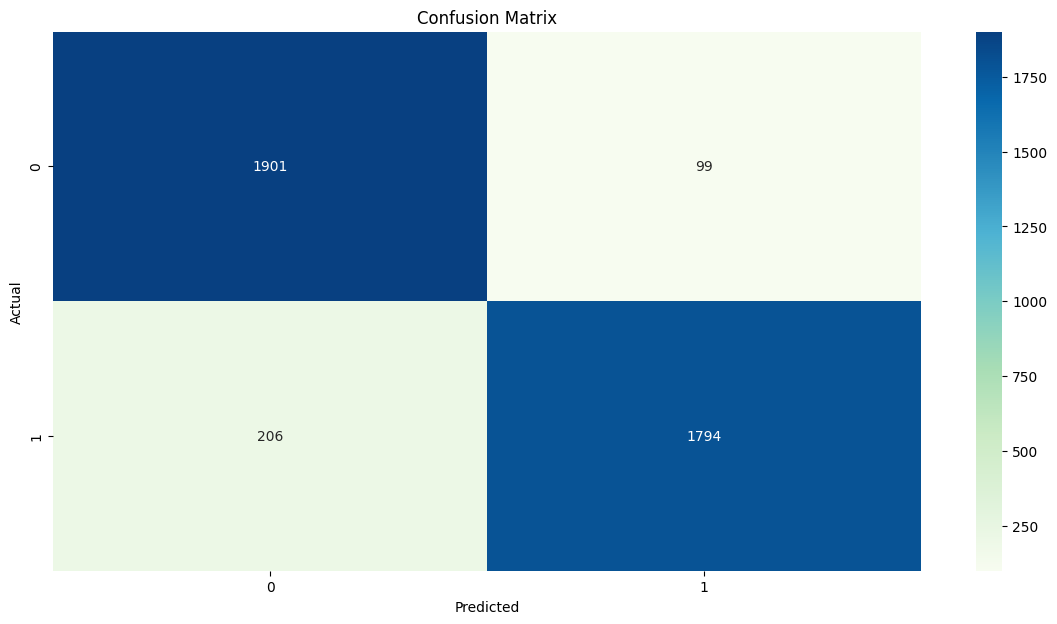

In [ ]:
# Plot the confusion matrix
# -------------------------

import seaborn as sns
plt.figure(figsize=(14, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, 
            fmt='d', cmap='GnBu')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## **Final Prediction System**

In [ ]:
# save the model
model.save("/kaggle/working/AI_vs_Real_Model.h5")

In [ ]:
# Load your trained ResNet

from tensorflow import keras
model = keras.models.load_model("/kaggle/working/AI_vs_Real_Model.h5")

In [ ]:
# Define Class Names
class_names = ["Real", "AI-Generated"]   # Adjust depending on how you labeled 0/1


In [ ]:
# We’ll make a function to preprocess + predict
# ---------------------------------------------

import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

def predict_image(model, img_path, class_names, target_size=(224,224)):
    # Load image and resize
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Preprocess for ResNet
    img_array = preprocess_input(img_array)
    
    # Prediction
    pred = model.predict(img_array)
    
    if pred.shape[1] == 1:  # sigmoid (binary)
        predicted_class = int(pred[0][0] > 0.5)  # threshold at 0.5
        confidence = pred[0][0] if predicted_class == 1 else 1 - pred[0][0]
    else:  # softmax (multiclass but only 2 classes)
        predicted_class = np.argmax(pred, axis=1)[0]
        confidence = pred[0][predicted_class]
    
    return class_names[predicted_class], float(confidence)


In [ ]:
# Test on a New Image
# ------------------

img_path = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/REAL/0000 (2).jpg"  # Replace with your test image path
label, confidence = predict_image(model, img_path, class_names)

print(f"Prediction: {label} (confidence: {confidence:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: Real (confidence: 1.00)


## **Deployment with Gradio**

In [ ]:
# Install Gradio
# --------------

!pip install gradio

In [ ]:
# Load Your Model
# ---------------

from tensorflow import keras

# Load trained model (update path as needed)
model = keras.models.load_model("/kaggle/working/AI_vs_Real_Model.h5")

# Define labels
class_names = ["Real", "AI-Generated"]


In [ ]:
# Define Preprocessing + Prediction Function
# ------------------------------------------

import numpy as np
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

def predict_image(img):
    # Ensure RGB (drop alpha channel if present)
    img = img.convert("RGB")

    # Resize to match model input
    img = img.resize((224, 224))

    # Convert to numpy
    img_array = np.array(img)

    # Expand dims for batch
    img_array = np.expand_dims(img_array, axis=0)

    # Apply same preprocessing as training
    img_array = preprocess_input(img_array)

    # Prediction
    pred = model.predict(img_array)

    if pred.shape[1] == 1:  # sigmoid output
        predicted_class = int(pred[0][0] > 0.5)
        confidence = pred[0][0] if predicted_class == 1 else 1 - pred[0][0]
    else:  # softmax
        predicted_class = np.argmax(pred, axis=1)[0]
        confidence = pred[0][predicted_class]

    return {class_names[predicted_class]: float(confidence)}


In [ ]:
# Create Gradio Interface
# -----------------------

import gradio as gr

interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=2),
    title="AI vs Real Image Detector",
    description="Upload an image to check whether it is AI-Generated or Real."
)

interface.launch(share=True)


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://b122fb7e7ee11d870c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
